In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import tensorflow as tf
import random
import pickle

from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env_mp_1 import MetaGames
from rmax_1 import RmaxAgent, Memory

def discretize(number, radius):
    #[0,3,5,4,8] --> [0,3,6,3,9] for radius 3
    return torch.round(torch.div(number, radius)) * radius

def Boltzmann(tensor):
    #0.5 is just a temperature parameter, controls the spread of the softmax distribution
    prob = tf.nn.softmax(tensor/0.4).numpy()
    action_value = np.random.choice(np.arange(tensor.size()[0]), p=prob)
    return torch.Tensor([action_value]).to(device)

2023-02-26 21:46:16.258006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 21:46:16.553921: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-26 21:46:26.092601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/system/easybuild/software/cuDNN/8.4.1.50-CUDA-11.7.0/lib:/apps/system/easybuild/s

In [2]:
inner_gamma = 0.5         #inner game discount factor
meta_gamma = 0.5          #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 1
meta_epi = 100
meta_steps = 50

epsilon = 0.2
radius = 1                #radius for discretization, assuming radius>1

In [3]:
#reward tensor for plotting purposes [episode, step, agents]
plot_rew = torch.zeros(meta_epi, meta_steps, 2).to(device)    

# creating environment
env = MetaGames("NL", "IPD")

# creating rmax agent
memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_gamma, radius, epsilon)

In [4]:
#initialise meta-state and meta-action randomly
meta_s = rmax.index_to_table(env, random.randint(0, rmax.meta_size * env.num_agents), env.num_agents)
memory.states.append(meta_s)
for episode in tqdm(range(meta_epi)): #for each meta-episode
    #reset environment 
    env.reset() 
    for step in range(meta_steps):    #for each meta time step
        #previous meta-state set as the policy of the next game
        env.innerq[0,:] = meta_s[0].detach().clone() 
        
        #meta-action = inner game Q table of our agent
        meta_a = env.innerq[0, :].detach().clone()
        memory.actions.append(meta_a) 
        #--------------------------------------START OF INNER GAME--------------------------------------  
        #select our inner-action with Boltzmann sampling, oppo inner-action with epsilon greedy 
        oppo_action = env.select_action().detach().clone()      
        our_action = Boltzmann(env.innerq[0,:].cpu().detach().clone())
        #print("inner actions: ", our_action, oppo_action)
        #run inner game according to actions
        reward, info = env.step(torch.cat((our_action, oppo_action))) 

        #update inner r matrix [agent, action]
        env.innerr[0, int(our_action)] = reward.detach().clone() 
        env.innerr[1, int(oppo_action)] = info.detach().clone()
        #---------------------------------------END OF INNER GAME--------------------------------------
        #Compute new inner Q table, our agent: meta_a that corresponds to max Q(meta_s)/ random, oppo: by Q learning
        env.innerq[0, :] = rmax.select_action(env, meta_s[0])
        env.innerq[1, :] = (1-meta_alpha) * env.innerq[1, :] + torch.Tensor([meta_alpha * info * oppo_action, meta_alpha * info * (1-oppo_action)]).to(device)
        #print("inner-r: ", reward, "\n inner-q: ", env.innerq)

        #meta-state = discretized inner game Q table of all agents
        new_meta_s = discretize(env.innerq.detach().clone(), radius)
        memory.states.append(new_meta_s)    

        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward.detach().clone()                
        memory.rewards.append(our_REW)

        #rmax update step
        rmax.update(env, memory, meta_s, meta_a, new_meta_s)
        #print("updating s-a pair:", rmax.find_meta_index( torch.flatten(meta_s)), rmax.find_meta_index( torch.flatten(meta_a)))
        #print("updating s-a pair:", rmax.find_meta_index( torch.flatten(meta_s)), rmax.find_meta_index( torch.flatten(meta_a)),"\nrmax.R: ", rmax.R, "\nrmax.Q: ", rmax.Q, "\nrmax.nSA: ", rmax.nSA)
        #print(meta_s, meta_a, new_meta_s)

        #prepare meta_s for next step
        meta_s = new_meta_s.detach().clone()


  0%|                                                       | 0/100 [00:00<?, ?it/s]2023-02-26 21:46:37.624021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 21:46:37.626449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42981 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:86:00.0, compute capability: 7.5
100%|█████████████████████████████████████████████| 100/100 [03:02<00:00,  1.82s/it]


In [ ]:
# Open a file and use dump()
with open('plot_rew' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(plot_rew, file)
    
# Open a file and use dump()
with open('memory' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(memory, file)

# Open a file and use dump()
with open('rmax' + str(datetime.now()) + '.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(rmax, file)

# Plots

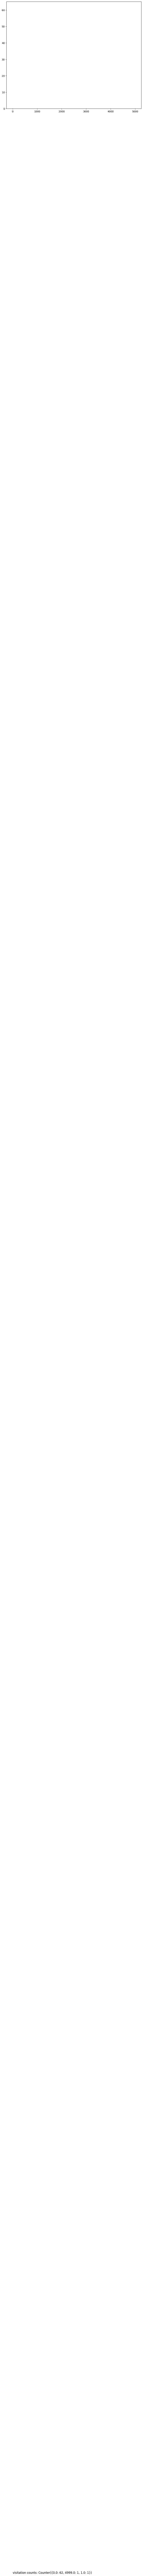

In [5]:
from datetime import datetime
from collections import Counter
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA.flatten().tolist())):
    visit_dict[i]= rmax.nSA.flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.text(0,-meta_epi*meta_steps*0.3 ,"visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
plt.savefig('histogram for' + str(datetime.now()) + '.png')

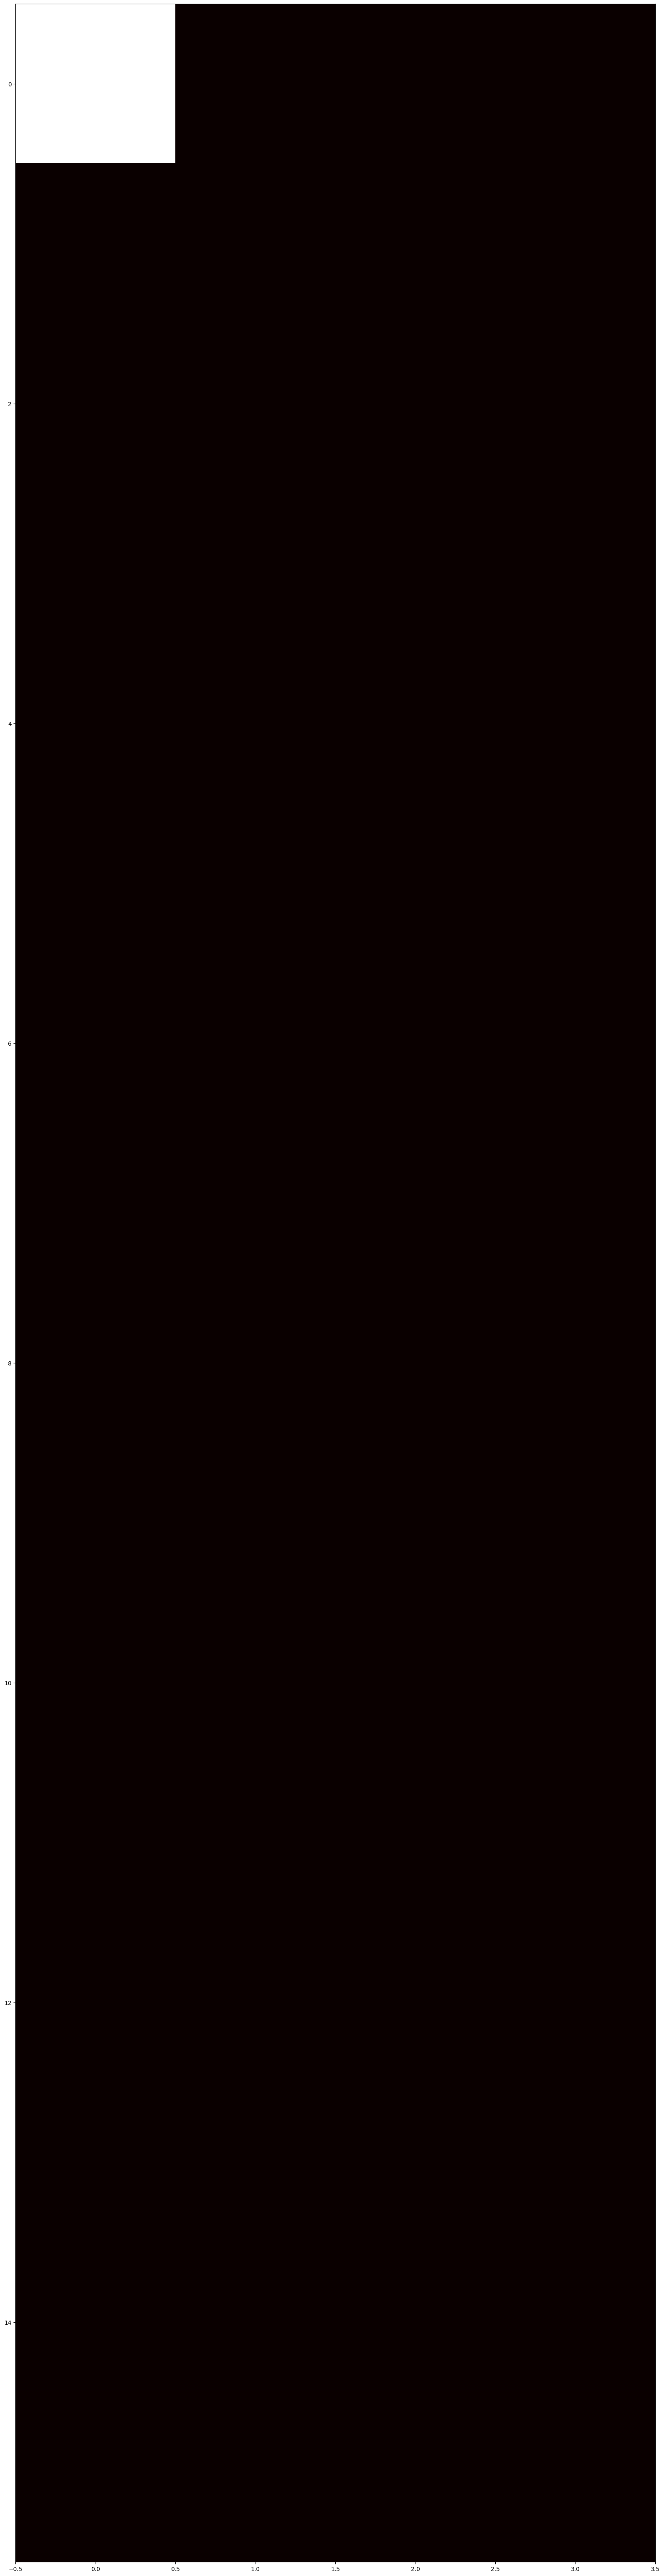

In [6]:
#generate heatmap
plt.imshow(rmax.nSA.cpu().numpy(), cmap='hot', interpolation='nearest')
figure1 = plt.gcf()
figure1.set_size_inches(100, 80)
plt.savefig('heatmap for' + str(datetime.now()) + '.png')

NameError: name 'max_meta_epi' is not defined

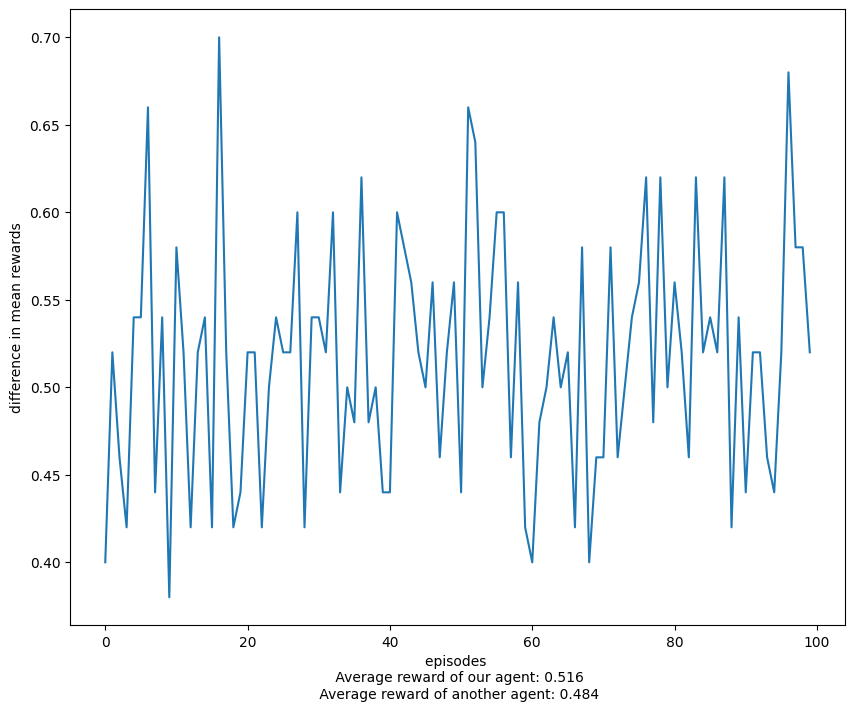

In [7]:
#generate reward mean
plot_rew_mean = torch.mean(plot_rew[:,:,0],1)# - torch.mean(plot_rew[:,:,1],1)
fig_handle = plt.plot(plot_rew_mean.cpu().numpy())

plt.xlabel("episodes \n Average reward of our agent: " + str(round(torch.mean(plot_rew[:,:,0],(0,1)).detach().item(), 3)) + 
          "\n Average reward of another agent: " + str(round(torch.mean(plot_rew[:,:,1],(0,1)).detach().item(), 3)))

plt.ylabel("difference in mean rewards")

figure2 = plt.gcf() # get current figure
figure2.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_mp1.png' , dpi = 100)
plt.clf()

In [9]:
#generate learning curve at start
plot_rew_epi_start = torch.mean(plot_rew[:int(meta_epi*0.1), :, 0], 0)
fig_handle = plt.plot(plot_rew_epi_start.cpu().numpy())

plt.xlabel("steps")

plt.ylabel("Average learning rate of first " + str(int(meta_epi*0.1)) + " episodes")

figure3 = plt.gcf() # get current figure
figure3.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + 'first_epi_mp1.png' , dpi = 100)
plt.clf()

<Figure size 1000x800 with 0 Axes>

In [10]:
#generate learning curve at end
plot_rew_epi_end = torch.mean(plot_rew[-int(meta_epi*0.1):, :, 0], 0)
fig_handle = plt.plot(plot_rew_epi_end.cpu().numpy())

plt.xlabel("steps")

plt.ylabel("Average learning rate of last " + str(int(meta_epi*0.1)) + " episodes")

figure4 = plt.gcf() # get current figure
figure4.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(meta_epi) + '_' + str(meta_steps) + '_last_epi_mp1.png' , dpi = 100)
plt.clf()

<Figure size 1000x800 with 0 Axes>

# Interpreting results 

In [3]:
import glob
path1 = "memory*.pkl"
path2 = "plot_rew*.pkl"
path3 = "rmax*.pkl"
for filename in glob.glob(path1):
    with open(filename, 'rb') as f:
        memory = pickle.load(f)
        
for filename in glob.glob(path2):    
    with open(filename, 'rb') as g:
        plot_rew = pickle.load(g)
        
for filename in glob.glob(path3):    
    with open(filename, 'rb') as g:
        rmax = pickle.load(g)        